In [239]:
import numpy as np
import tensorflow as tf
import math
import logging
# logging.basicConfig(level=logging.DEBUG)
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

In [241]:
df = pd.read_csv('pearson_air_quality.csv', header=None)

In [242]:
batch_x1=df[0]
batch_x2=df[1]
batch_y1=df[2]
label=batch_y1#+1e-50-1e-50
batch_x=np.column_stack((batch_x1, batch_x2)) 
batch_y=np.row_stack(batch_y1)

In [243]:
def multilayer_perceptron(input_d, activation_type, weight, bias, n_layer):
    # layer = tf.nn.sigmoid(tf.add(tf.matmul(input_d, weight[0]), bias[0])) if activation_type == "Sigmoid" else tf.nn.relu(tf.add(tf.matmul(input_d, weight[0]), bias[0]))
    # for i in range(1, len(bias)-2):
    #     layer = tf.nn.sigmoid(tf.add(tf.matmul(layer, weight[i]), bias[i])) if activation_type == "Sigmoid" else tf.nn.relu(tf.add(tf.matmul(layer, weight[i]), bias[i]))
    # out_layer = tf.add(tf.matmul(layer, weight[len(weight)-1]), bias[len(bias)-1])

    last_layer = None
    last_hidden = None
    layer = [0 for i in range (0,n_layer+1)]
    layer[0] = input_d
    for i in range(0,n_layer):
        if activation_type == 0:
            layer[i+1] = tf.nn.sigmoid(tf.add(tf.matmul(layer[i], w[i]), b[i]))
        else:
            layer[i+1] = tf.nn.relu(tf.add(tf.matmul(layer[i], w[i]), b[i]))
            
        last_layer = layer[i+1]
        last_hidden = n_hidden[i]

    out_weight = tf.Variable(tf.random_normal([last_hidden, n_output]))
    out_layer = tf.add(tf.matmul(last_layer, out_weight),b[-1])
    return out_layer

In [244]:
def train_neural_network(X, Y, activation_type, weight, bias, n_hidden, learning_constant, number_epochs, batch_size):
    neural_network = multilayer_perceptron(X, activation_type, weight, bias, len(n_hidden))
    loss_op = tf.reduce_mean(tf.math.squared_difference(neural_network,Y))
    optimizer = tf.train.GradientDescentOptimizer(learning_constant).minimize(loss_op)
    init = tf.global_variables_initializer()
    with tf.Session() as sess: 
        sess.run(init)
        #Training epoch
        batch_x_train=batch_x[0:3999] 
        batch_y_train=batch_y[0:3999]
        batch_x_test=batch_x[4000:batch_size] 
        batch_y_test=batch_y[4000:batch_size]
        label_train=label[0:3999] 
        label_test=label[4000:batch_size]
        for epoch in range(int(number_epochs)):
            sess.run(optimizer, feed_dict={X: batch_x_train, Y: batch_y_train})
            #Display the epoch
            # if epoch % 100 == 0:
            #     print("Epoch:", '%d' % (epoch))
        pred = (neural_network)
        prediction = pred.eval({X: batch_x_test})
        rmse = mean_squared_error(label_test, prediction, squared=False)
        return rmse

<h1> Tuning Hyperparameter

In [ ]:
import itertools
hidden_layers = [1,2,3]
n_input = 2
n_output = 1

#Learning parameters
learning_constants = [0.1, 0.2, 0.5]
number_epochss = [10, 20, 50]
batch_size = 6000

# topology, (weight & bias), learning rate, epochs, sizes
lowest_rmse = 999
lowest_rmse_data = []

for hidden_layer in hidden_layers:
    n_hiddens = []
    for i in range(hidden_layer):
        n_hiddens.append([1, 2, 3, 5, 10])
    n_hiddens = (itertools.product(*n_hiddens))

    for n_hidden in n_hiddens:
        # bias = []
        # for i in n_hidden:
        #     bias.append(tf.Variable(tf.random_normal([i])))
        # bias.append(tf.Variable(tf.random_normal([n_output])))

        # weight = []
        # weight.append(tf.Variable(tf.random_normal([n_input, n_hidden[0]])))
        # for i in range(len(n_hidden)-1):
        #     weight.append(tf.Variable(tf.random_normal([n_hidden[i], n_hidden[i+1]])))
        # weight.append(tf.Variable(tf.random_normal([n_hidden[len(n_hidden)-1], n_output])))

        n_hiddens_permutation = n_hidden
        b = []
        w = []
        for i in range (0,len(n_hiddens_permutation)):
            b.append(tf.Variable(tf.random_normal([n_hiddens_permutation[i]])))
        b.append(tf.Variable(tf.random_normal([n_output])))

        w.append(tf.Variable(tf.random_normal([n_input, n_hiddens_permutation[0]])))
        for i in range (0,len(n_hiddens_permutation)-1):
            w.append(tf.Variable(tf.random_normal([n_hiddens_permutation[i], n_hiddens_permutation[i+1]])))

        for learning_constant in learning_constants:
            for number_epochs in number_epochss:
                for j in ['Sigmoid', 'Relu']:
                    # j='Relu'
                    X = tf.placeholder("float", [None, n_input])
                    Y = tf.placeholder("float", [None, n_output])
                    rmse = train_neural_network(X, Y, j, w, b, n_hidden, learning_constant, number_epochs, batch_size)
                    print("ANN:",n_hidden)
                    print("ANN Layer:",len(n_hidden))
                    print("Learning Rate:",learning_constant)
                    print("Epoch:",number_epochs)
                    print("Activation Type:", j)
                    print("RMSE:", rmse)
                    print("=========================================================")
                    if lowest_rmse > rmse:
                        lowest_rmse = rmse
                        lowest_rmse_data = [n_hidden, len(n_hidden), learning_constant, number_epochs, j]


In [246]:
lowest_rmse

0.06884864823422532

In [247]:
lowest_rmse_data

[(3,), 1, 0.2, 20, 'Relu']

<h1> K-10 Fold Cross-validation RMSE

In [255]:
def evaluate_neural_network(k, X, Y, activation_type, weight, bias, n_hidden, learning_constant, number_epochs, batch_size):
    train_size = 400
    total_RMSE = 0
    for i in range(k):
        print("======================K-"+str(i+1)+"==========================")
        neural_network = multilayer_perceptron(X, activation_type, weight, bias, len(n_hidden))
        loss_op = tf.reduce_mean(tf.math.squared_difference(neural_network,Y))
        optimizer = tf.train.GradientDescentOptimizer(learning_constant).minimize(loss_op)
        init = tf.global_variables_initializer()
        with tf.Session() as sess: 
            sess.run(init)
                
            train_range = int((batch_size/k)*i) # 6000/10 = 600 * 1 = 600
            test_range = int((batch_size/k)*(i+1)) # 6000/10 = 600 * 2 = 1200
            batch_x_train=batch_x[train_range:train_range+train_size-1] 
            batch_y_train=batch_y[train_range:train_range+train_size-1]
            batch_x_test=batch_x[train_range+train_size:test_range] 
            batch_y_test=batch_y[train_range+train_size:test_range]
            label_train=label[train_range:train_range+train_size-1] 
            label_test=label[train_range+train_size:test_range]

            #Training epoch
            for epoch in range(number_epochs):
                sess.run(optimizer, feed_dict={X: batch_x_train, Y: batch_y_train})
                #Display the epoch
                # if epoch % 100 == 0:
                #     print("Epoch:", '%d' % (epoch))

            # Test model
            pred = (neural_network) # Apply softmax to logits
            accuracy=tf.keras.losses.MSE(pred,Y)
            # print("Accuracy:", accuracy.eval({X: batch_x_train, Y:batch_y_train})) 
            # print("Prediction:", pred.eval({X: batch_x_test})) 
            output=neural_network.eval({X: batch_x_test}) 
            plt.plot(batch_y_test, 'ro', output, 'bo') 
            plt.ylabel('Predicted CO(GT) value')
            plt.show()

            prediction = pred.eval({X: batch_x_test})
            rmse = mean_squared_error(label_test, prediction, squared=False)
            print("RMSE:", rmse)
            total_RMSE += rmse
            # print(math.sqrt(sum(accuracy.eval({X: batch_x_test, Y:batch_y_test}))/len(batch_x_test)))
    print("====================================================")
    print("Average RMSE:",total_RMSE/k)

======================K-1==========================


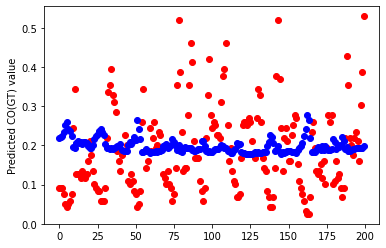

RMSE: 0.11810460086650715
======================K-2==========================


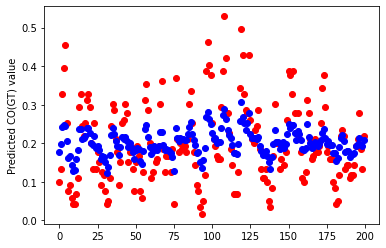

RMSE: 0.0719564388298521
======================K-3==========================


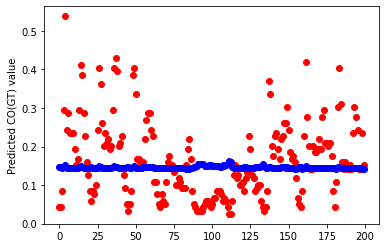

RMSE: 0.1033391200414549
======================K-4==========================


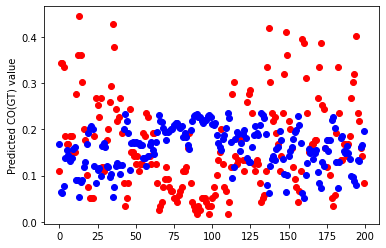

RMSE: 0.14581283126667238
======================K-5==========================


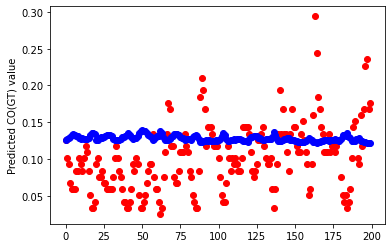

RMSE: 0.054767482328874253
======================K-6==========================


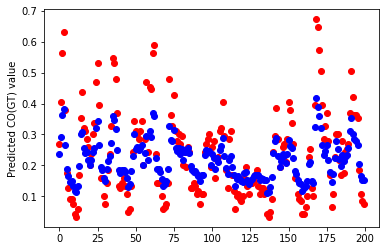

RMSE: 0.07959319827624352
======================K-7==========================


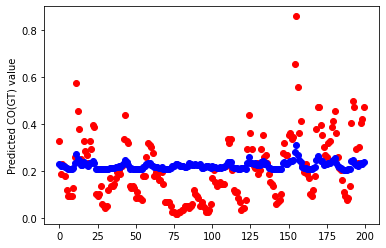

RMSE: 0.12757740675756243
======================K-8==========================


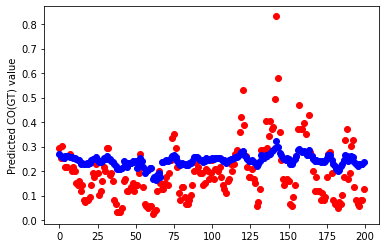

RMSE: 0.1086384484442463
======================K-9==========================


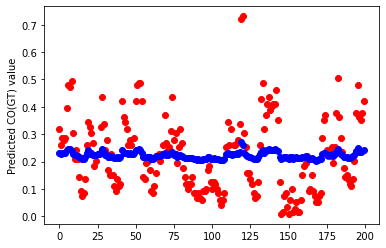

RMSE: 0.12405848880247775
======================K-10==========================


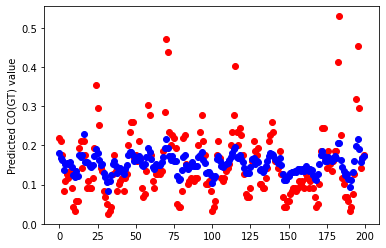

RMSE: 0.06524861676097422
Average RMSE: 0.0999096632374865


In [256]:
n_input = 2
n_output = 1

#Learning parameters
learning_constants = 0.2
number_epochss = 20
batch_size = 6000

n_hidden = [3]
n_hiddens_permutation = n_hidden
b = []
w = []
for i in range (0,len(n_hiddens_permutation)):
    b.append(tf.Variable(tf.random_normal([n_hiddens_permutation[i]])))
b.append(tf.Variable(tf.random_normal([n_output])))

w.append(tf.Variable(tf.random_normal([n_input, n_hiddens_permutation[0]])))
for i in range (0,len(n_hiddens_permutation)-1):
    w.append(tf.Variable(tf.random_normal([n_hiddens_permutation[i], n_hiddens_permutation[i+1]])))

j=0
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_output])
evaluate_neural_network(10, X, Y, j, w, b, n_hidden, learning_constant, number_epochs, batch_size)